In [1]:
import sys
sys.path.insert(1, 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\impedance.py') #\\impedance')
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from impedance.models.circuits import CustomCircuit
from impedance.visualization import plot_nyquist
from impedance import preprocessing
from impedance import validation
from impedance.validation import linKK

import ImpedanceCorrection as IC
import IC_plotting
%reload_ext autoreload
%autoreload 2

In [2]:
direc = r'\Data'
print(os.getcwd())
all_files=glob.glob(os.getcwd() + direc + '\*1%*.par')
all_files.sort()

f_name=all_files[-1]
print(f_name)
f0, Z0= preprocessing.readVersaStudio(f_name)

freqs, Z1 = preprocessing.ignoreBelowX(f0, Z0)

Z = Z1 - Z1.real[0]

C:\Users\shadd\OneDrive\Documents\Python\EIS
C:\Users\shadd\OneDrive\Documents\Python\EIS\Data\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before2.par


In [3]:
M, mu, Z_linKK, res_real, res_imag = linKK(freqs, Z1, c=.8, max_M=100)

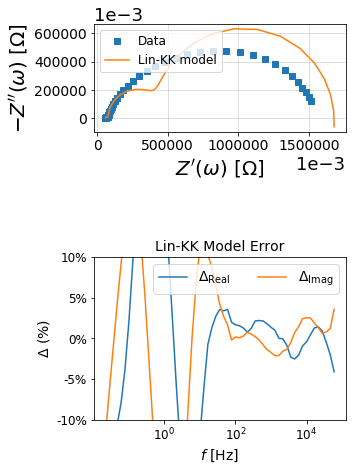

In [4]:
fig = plt.figure(figsize=(5,8))
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[:2,:])
ax2 = fig.add_subplot(gs[2,:])

# plot original data
plot_nyquist(ax1, Z1, fmt='s')

# plot measurement model
plot_nyquist(ax1, Z_linKK, fmt='-', scale=1e3, units='\Omega')

ax1.legend(['Data', 'Lin-KK model'], loc=2, fontsize=12)

# Plot residuals
ax2.plot(freqs, res_real, '-', label=r'$\Delta_{\mathrm{Real}}$')
ax2.plot(freqs, res_imag, '-', label=r'$\Delta_{\mathrm{Imag}}$')
ax2.set_title('Lin-KK Model Error', fontsize=14)

ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_ylabel('$\Delta$ $(\%)$', fontsize=14)
ax2.set_xlabel('$f$ [Hz]', fontsize=14)
ax2.set_xscale('log')
ax2.set_ylim(-.1, .1)

ax2.legend(loc=1, fontsize=14, ncol=2)

vals = ax2.get_yticks()
ax2.set_yticklabels(['{:.0%}'.format(x) for x in vals])

plt.tight_layout()
plt.show()

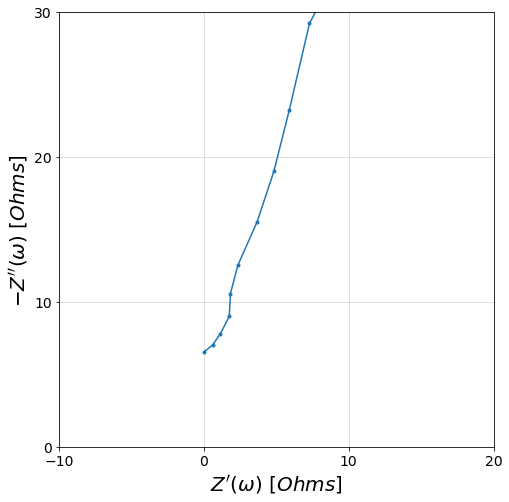

In [5]:
f_adj, Z_adj = freqs[17:], Z1[17:]

Z_adj = Z_adj - Z_adj.real[0]

fig, ax = plt.subplots(figsize=(8,8))

plot_nyquist(ax, Z_adj)

ax.set_xlim(-10, 20)
ax.set_ylim(0,30)
plt.show()

### Subtracting a Gerischer admittance from this using tg=0.7 as fit from fr-XAS
### Varying the Rg to see what might be appropriate

26 (3113.5652647521993-4034.3610571697736j) 506.71554302813956 14 13
26 (2669.994999727904-3187.6559335926986j) 348.8837103909659 13 11
26 (2336.1334541780648-2642.2259456152383j) 236.00254279726278 11 10
26 (2079.907208769804-2263.75049544761j) 157.9173273669453 10 7
26 (1878.511515105389-1986.6863285215925j) 103.43213686799936 8 2
26 (1716.6781603606214-1775.557867173412j) 64.70134507818943 6 1
26 (1584.1125860175605-1609.5950975500878j) 36.61721377460958 4 1
26 (1473.718098739434-1475.8701270730578j) 15.871645348108586 3 1
26 (1380.479689532002-1365.9328181338574j) 0.2914105585296056 3 1
26 (1300.7681016846175-1274.0348474470293j) -11.579899146034222 3 1
26 (1231.899150128491-1196.1339221925257j) -20.738915192571312 3 1
26 (1171.8483981545855-1129.3067706290713j) -27.881500224705178 2 0
26 (1119.062038468006-1071.3881979961163j) -33.50269813954537 1 0
27 (1272.3267746867848-1023.1126904965543j) 18.228424490721864 1 0
27 (1221.2380598330444-981.7934941158122j) 10.132468169909316 1 0


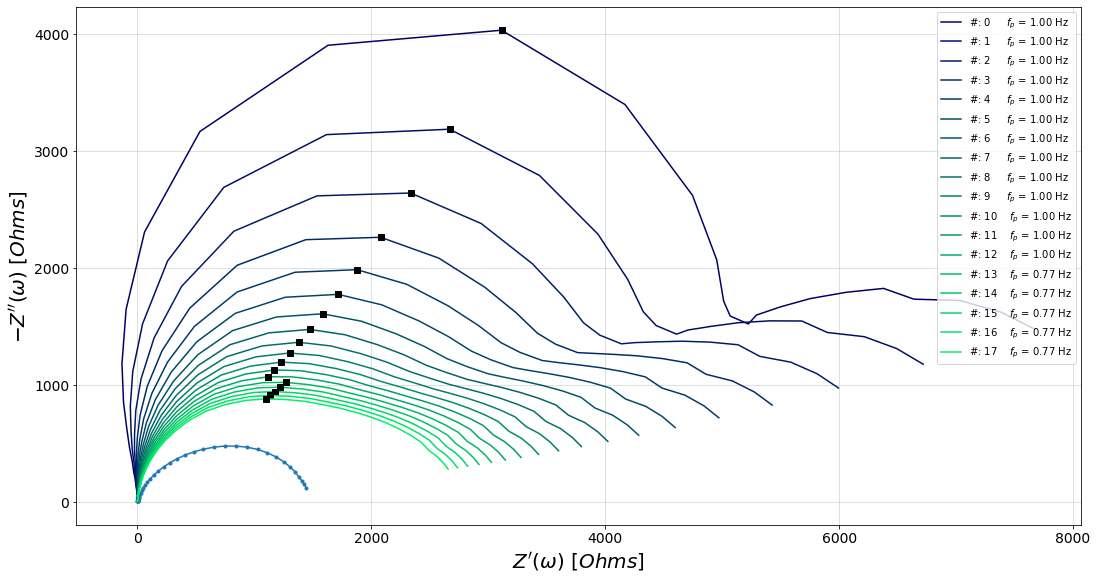

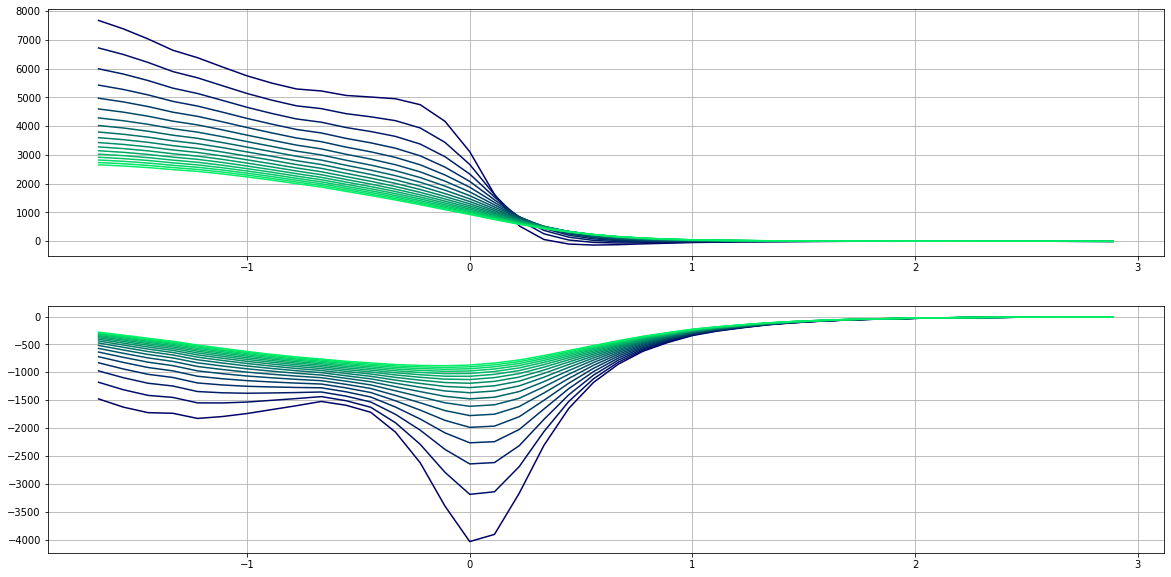

In [6]:
# par_out, ax0, ax1, ax2 = IC.sub_Zg_parallel(f_adj, Z_adj, .7, [3.3, 3.8], num=13)
par_out = IC.sub_Zg_parallel(f_adj, Z_adj, .91, [3.25, 3.5], num=18, show_plot=False)
# ax0.set_xlim((-2, 20))
# ax0.set_ylim((-2, 20))
fig, ax = plt.subplots(figsize=(18, 12))
fig2, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 10))
plot_nyquist(ax, Z_adj)

for i, Zs in enumerate(par_out):
#     print(sum(n < 0 for n in np.diff(Zs)), sum(n < -1 for n in Zs.real))
    min_ind = np.argmin(Zs.imag)
    print(min_ind, Zs[min_ind], Zs[min_ind+1].imag - Zs[min_ind-1].imag, sum(n < 0 for n in np.diff(Zs)), sum(n < -1 for n in Zs.real))
    #if sum(n < 0 for n in np.diff(Zs)) == 0 and sum(n < -1 for n in Zs.real) < 2:
    f_p_idx = np.argmin(np.imag(Zs))
    f_p = f_adj[f_p_idx]

    ax.plot(Zs.real, -Zs.imag, label='#: %d \t $f_p$ = %.2f Hz' % (i, f_p),
            c=(0, i/len(par_out), .4))
    ax.plot(Zs[f_p_idx].real, -Zs[f_p_idx].imag, 's',
            c=(0, 0, 0))
    ax1.plot(np.log10(f_adj), Zs.real, label='%.2f Hz' % f_p,
            c=(0, i/len(par_out), .4))
    ax2.plot(np.log10(f_adj), Zs.imag, label='%.2f Hz' % f_p,
            c=(0, i/len(par_out), .4))

#     ax.set_xlim(-80, 300)
#     ax.set_ylim(-80, 300)
    ax1.grid(True)
    ax2.grid(True)
    ax.legend()
# fig.savefig(r'Figures\Berthier Correction\1%O2 Data Zg Subtraction Nyquist', dpi=300, bbox_inches='tight')
# fig2.savefig(r'Figures\Berthier Correction\1%O2 Data Zg Subtraction Bode', dpi=300, bbox_inches='tight')

In [7]:
def Res_fun(Rg, f, Z, tg):
    from impedance.models.circuits.elements import G
    Y = 1 / Z
    p = [Rg[0], tg]
    Zg = G(p, f)
    Yg = 1 / Zg
    Y_adj = Y - Yg
    Z_adj = 1 / Y_adj
    
    min_ind = np.argmin(Z_adj.imag)
    
#     n=1
#     res = Z_adj[min_ind+1].imag - Z_adj[min_ind-1].imag
    res = 0
    for n in range(1, 5):
        res = (Z_adj[min_ind+n].imag - Z_adj[min_ind-n].imag)**2
    print(min_ind, Rg, res, np.min(Z_adj.imag))
#     print(min_ind, Z_adj[min_ind], Z_adj[min_ind+1].imag - Z_adj[min_ind-1].imag
    return res

In [8]:
Res_fun([9300], f_adj, Z_adj, 0.7)

29 [9300] 577.759924535099 -560.4450111540832


577.759924535099

      fun: 82653.97753641343
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.64418452])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 188
      nit: 3
   status: 2
  success: False
        x: array([10627.49666061])


0.3593814

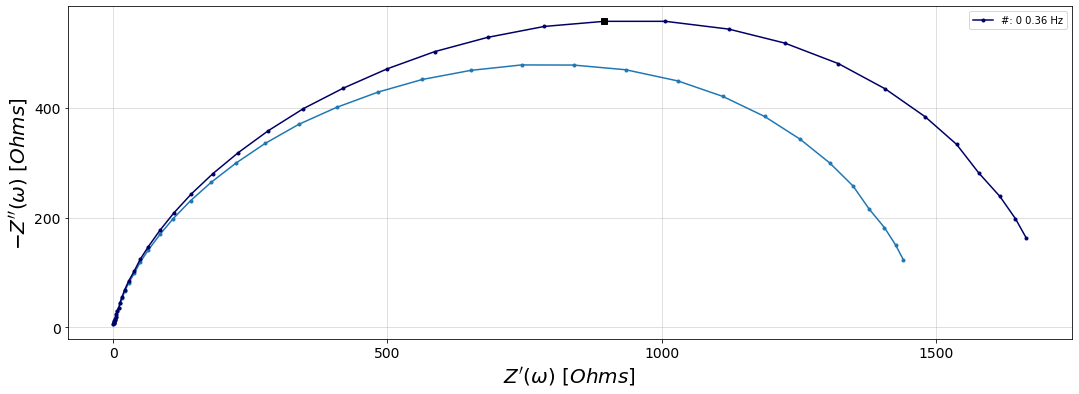

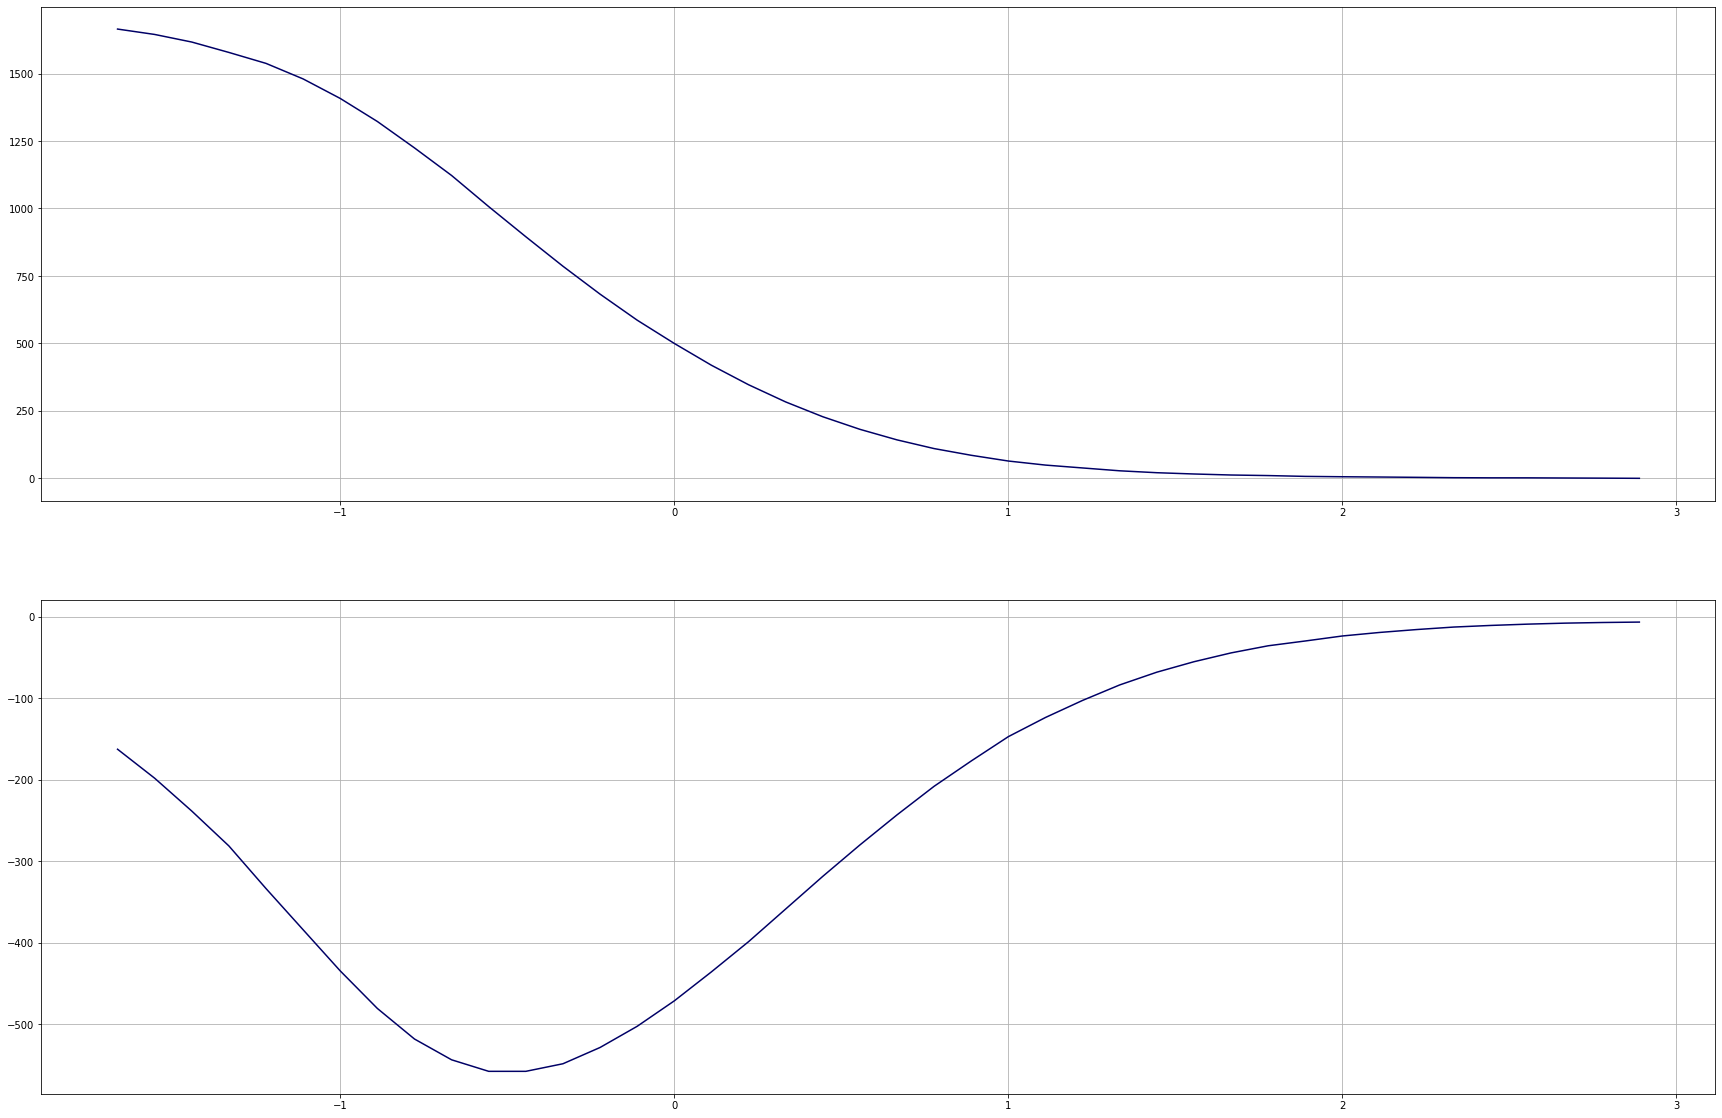

In [9]:
Zg0 = [11000] #, 0.7]
tg0 = .1
opts = {'maxiter': 10000}
Zg_fit = minimize(IC.Par_Zg_Res, Zg0, method='L-BFGS-B', args=(f_adj, Z_adj, tg0), bounds=((0, None),), options=opts)
# Zg_fit = minimize(Res_fun, Zg0, args=(f_adj, Z_adj, tg0), bounds = ((0, None),), options=opts)
print(Zg_fit)
# IC.sub_Zg_parallel(f_adj, Z_adj, Zg_fit.x[1], [Zg_fit.x[0]], num=1)
yy = IC.sub_Zg_parallel(f_adj, Z_adj, tg0, Zg_fit.x, num=1)
# IC.sub_Zg_parallel(f_adj, Z_adj, .7, [3.5, 4], num=3)
IC.detect_peak_f(f_adj, yy[0])

In [10]:
from scipy.optimize import least_squares

In [11]:
result = least_squares(Res_fun, 10**3.9, args=(f_adj, Z_adj, .7), bounds=([1e3], [1e4]))
result

29 [7943.28234724] 618.0297175420249 -577.3619772665583
29 [7943.28246561] 618.0297132250239 -577.3619754864737
29 [9777.38657047] 566.9428971049025 -555.7896233226421
29 [9777.38671617] 566.9428940073045 -555.7896219824441
29 [9998.15695892] 562.3793632484687 -553.810732281287
29 [9998.1571079] 562.3793602543079 -553.810730979991
29 [9999.99987862] 562.3423343277613 -553.7946388078587
29 [9999.99972961] 562.3423373210928 -553.7946401088392
29 [10000.] 562.3423318895052 -553.7946377481225
29 [9999.99985099] 562.3423348828179 -553.7946390491029


 active_mask: array([1])
        cost: 158114.4491174632
         fun: array([562.34233189])
        grad: array([-11.29620991])
         jac: array([[-0.02008778]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 5
        njev: 5
  optimality: 2.0547686117539733e-11
      status: 1
     success: True
           x: array([10000.])

[1.91377151e-20 1.78644568e+03 2.72170094e-04 7.19254833e-01]
[9.51899085e+03 8.84238440e-01]


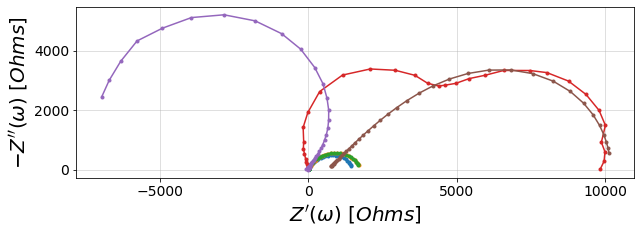

In [12]:
par_out= IC.sub_Zg_parallel(f_adj, Z_adj, .7, result.x, num=11, show_plot=False)

f_p = f_adj[np.argmin(par_out.imag)]
C_guess = 1 / (2*np.pi * f_p * par_out[0, -1].real)
PostZg = CustomCircuit(circuit='R0-p(R1,E1)', initial_guess=[par_out[0,15].real, par_out[0,-1].real, C_guess, .8])
PostZg.fit(f_adj[15:], par_out[0, 15:])
print(PostZg.parameters_)
Z_pZg = PostZg.predict(f_adj[15:]) 

ZZ = IC.par_RCPE_subtract(PostZg.parameters_[1:], f_adj, Z_adj)
ZZ2 = IC.par_RCPE_subtract([1227.361, 8.5e-5, .90185877], f_adj, Z_adj)

dum_circ = CustomCircuit(circuit='R1-G', initial_guess=[None, 12000, .2], constants={'R1': 650})
dum_circ.fit(f_adj, ZZ)

ZZ_p = dum_circ.predict(f_adj)
print(dum_circ.parameters_)

fig, ax = plt.subplots(figsize=(10,10))
plot_nyquist(ax, Z_adj)
plot_nyquist(ax, Z_pZg)
plot_nyquist(ax, par_out[0])
plot_nyquist(ax, ZZ)
plot_nyquist(ax, ZZ2)
plot_nyquist(ax, ZZ_p)

# ax.set_xlim(0,800)
# ax.set_ylim(-200,700)

In [13]:
dum_circ = CustomCircuit(circuit='R1-G', initial_guess=[None, 12000, .2], constants={'R1': 800})
dum_circ.fit(f_adj, ZZ)

ZZ_p = dum_circ.predict(f_adj)



In [14]:
RC0 = PostZg.parameters_[1:]
print(RC0)
d_st = 3e-16
x_t = xtol=3e-16
f_t = ftol=3e-16
g_t = gtol=3e-16


resRCPE = least_squares(IC.Par_RCPE_Res, RC0, method= 'trf', args=(f_adj, Z_adj), max_nfev=2000, diff_step=d_st, xtol=x_t, ftol=f_t, gtol=g_t)
resRCPE

[1.78644568e+03 2.72170094e-04 7.19254833e-01]


 active_mask: array([0., 0., 0.])
        cost: 4.850665002744825e-07
         fun: array([0.00098495])
        grad: array([0.00000000e+00, 7.11928658e-07, 6.41245637e-06])
         jac: array([[0.        , 0.0007228 , 0.00651042]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 35
        njev: 9
  optimality: 6.412456371509988e-06
      status: 3
     success: True
           x: array([1.78644568e+03, 2.42434857e-04, 7.19255479e-01])

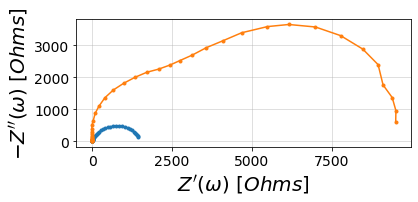

In [15]:
ZZZ = IC.par_RCPE_subtract(resRCPE.x, f_adj, Z_adj)

fig, ax = plt.subplots()
plot_nyquist(ax, Z_adj)
plot_nyquist(ax, ZZZ)

In [16]:
direc = r'\Data'
print(os.getcwd())
all_files=glob.glob(os.getcwd() + direc + '\*1%*.par')
all_files.sort()

f_name=all_files[-1]
print(f_name)
f0, Z0 = preprocessing.readVersaStudio(f_name)

freqs, Z1 = preprocessing.ignoreBelowX(f0, Z0)

Z = Z1 - Z1.real[0]

C:\Users\shadd\OneDrive\Documents\Python\EIS
C:\Users\shadd\OneDrive\Documents\Python\EIS\Data\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before2.par


29 (981.2784725821963-615.8372308158823j) 2.842571984653887 1 0
29 (967.4493237993786-607.9868984650849j) 1.925760153748456 0 0
29 (954.6007238814498-600.67303824878j) 1.0942752349511693 0 0
29 (942.644231991444-593.8495259376065j) 0.3381741533000877 0 0
29 (931.5014991619813-587.475232685716j) -0.3510912101419308 0 0
29 (921.1028680088378-581.5133674458889j) -0.980901268627008 0 0
29 (911.3861994917664-575.930920541752j) -1.5576540886437442 0 0
29 (902.2958849163548-570.6981907327322j) -2.086917434681368 0 0
29 (893.7820099385121-565.7883815384571j) -2.573554154025942 0 0
29 (885.7996439757408-561.1772552902413j) -3.0218260995286528 0 0
29 (878.3082336154662-556.8428355162781j) -3.435480677289661 0 0


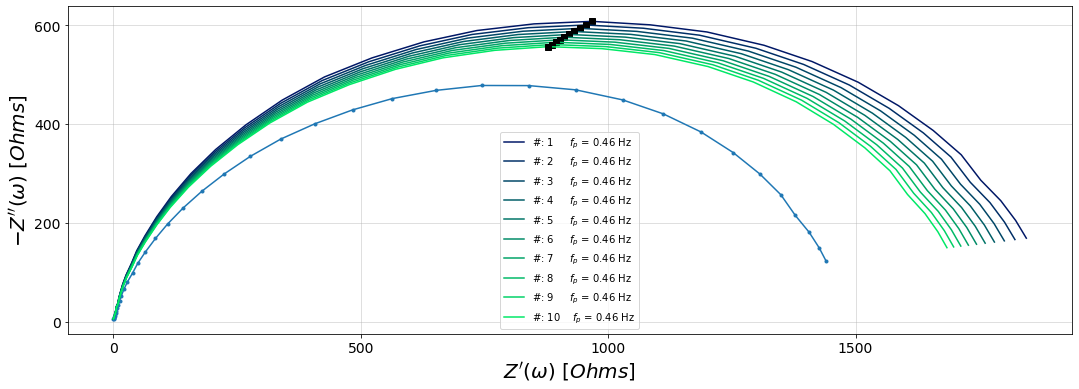

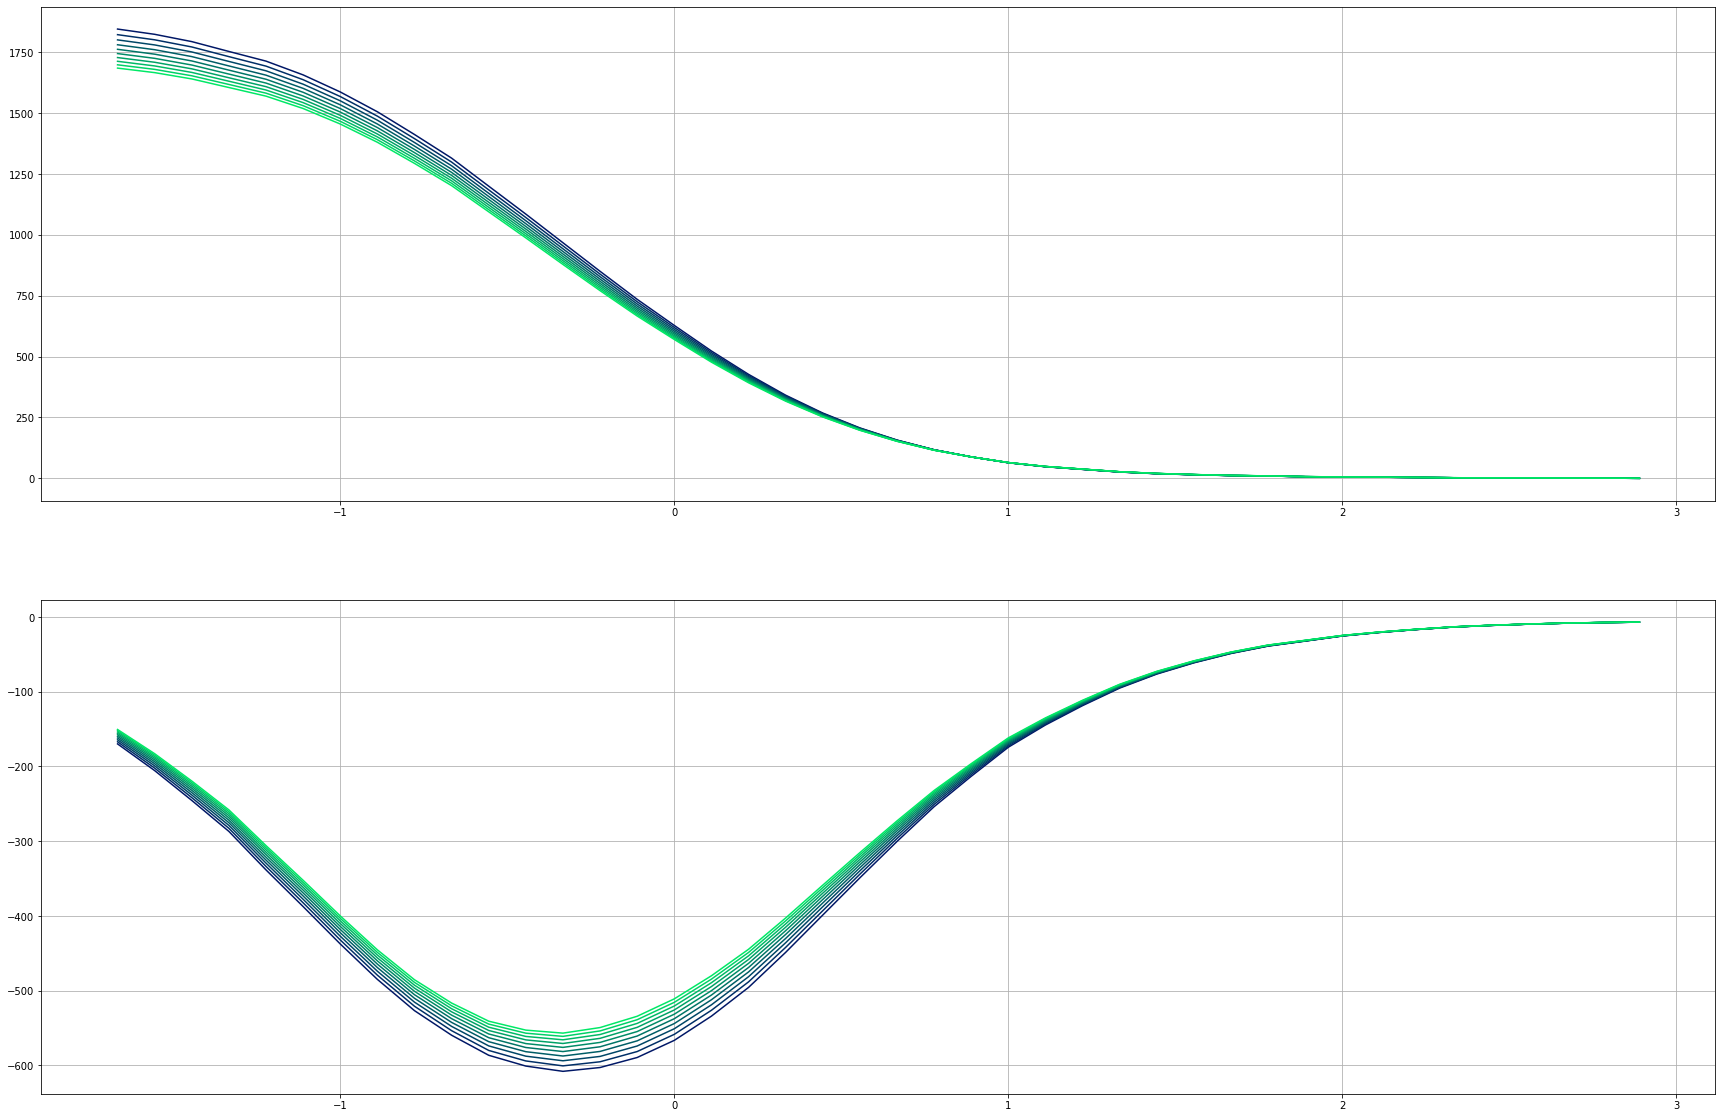

In [17]:
# par_out, ax0, ax1, ax2 = IC.sub_Zg_parallel(f_adj, Z_adj, .7, [3.3, 3.8], num=13)
par_out = IC.sub_Zg_parallel(f_adj, Z_adj, .91, [3.8, 4], num=11, show_plot=False)
# ax0.set_xlim((-2, 20))
# ax0.set_ylim((-2, 20))
fig, ax = plt.subplots(figsize=(18, 12))
fig2, (ax1, ax2) = plt.subplots(nrows=2, figsize=(30, 20))
plot_nyquist(ax, Z_adj)

for i, Zs in enumerate(par_out):
#     print(sum(n < 0 for n in np.diff(Zs)), sum(n < -1 for n in Zs.real))
    min_ind = np.argmin(Zs.imag)
    print(min_ind, Zs[min_ind], Zs[min_ind+1].imag - Zs[min_ind-1].imag, sum(n < 0 for n in np.diff(Zs)), sum(n < -1 for n in Zs.real))
    if sum(n < 0 for n in np.diff(Zs)) == 0 and sum(n < -1 for n in Zs.real) < 2:
        f_p_idx = np.argmin(np.imag(Zs))
        f_p = f_adj[f_p_idx]

        ax.plot(Zs.real, -Zs.imag, label='#: %d \t $f_p$ = %.2f Hz' % (i, f_p),
                c=(0, i/len(par_out), .4))
        ax.plot(Zs[f_p_idx].real, -Zs[f_p_idx].imag, 's',
                c=(0, 0, 0))
        ax1.plot(np.log10(f_adj), Zs.real, label='%.2f Hz' % f_p,
                c=(0, i/len(par_out), .4))
        ax2.plot(np.log10(f_adj), Zs.imag, label='%.2f Hz' % f_p,
                c=(0, i/len(par_out), .4))

        # ax.set_xlim(-80, 300)
        # ax.set_ylim(-80, 300)
        ax1.grid(True)
        ax2.grid(True)
        ax.legend()
        

C:\Users\shadd\OneDrive\Documents\Python\EIS


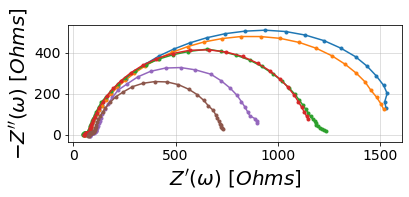

In [18]:
direc = r'\Data'
print(os.getcwd())
all_files=glob.glob(os.getcwd() + direc + '\*.par')
all_files.sort()

fig, ax = plt.subplots()

for file in all_files:
    f, Z = preprocessing.readVersaStudio(file)
    plot_nyquist(ax, Z)

    
# ax.set_xlim(40,150)
# ax.set_ylim(0,100)
plt.show()

In [19]:
all_files

['C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before2.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_10%_EIS_OCV_after.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_10%_EIS_OCV_afterFRXAS.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_100%_EIS_OCV_after.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_100%_EIS_OCV_before2.par']

In [20]:
from impedance.validation import linKK

In [21]:
linKK()

TypeError: linKK() missing 2 required positional arguments: 'f' and 'Z'